# Gradient descent with pytorch

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

Let us consider the rosenbrock function $f(x,y) = 100(y-x^2)^2 + (1-x)^2$ 

We will in this practical session see what automatoc differentiation is with pytorch, and how to optimize with pytorch


In [4]:
def rosenbrok(x):
    ## YOUR CODE HERE
    f =  100 * (x[1] - x[0]**2)**2 + (1 - x[0])**2
    return f

In [5]:
# !pip install torch
import torch

In [6]:
x = torch.tensor([.5,.5], requires_grad=True, dtype=torch.float64)

n_iter = 10000
lr = torch.tensor(0.001, dtype=torch.float64)


# define optimizer 
optimizer = torch.optim.SGD([x], lr=lr)

for i in range(1, n_iter):
    # zero out the gradient (by default PyTorch accumulates gradients)
    optimizer.zero_grad()
    y = rosenbrok(x)
    # compute the gradient
    y.backward(retain_graph=True)
    # apply GD step
    optimizer.step()
print("Final value: ",x)

Final value:  tensor([0.9960, 0.9919], dtype=torch.float64, requires_grad=True)


### TODO:
try different initial conditions and learning rate
see if schema is more robust, change optimizer

# Automatic differentiation in pytorch


In [7]:
x = torch.tensor(1., requires_grad=True)
y = torch.tensor(3., requires_grad=True)
z=x**2 + torch.log(y)

In [8]:
print("Value of z: ",z)
z.backward()

Value of z:  tensor(2.0986, grad_fn=<AddBackward0>)


In [9]:
dx=x.grad
dy=y.grad
print("Gradient w.r.t. x : ",dx)
print("Gradient w.r.t. y : ",dy)

Gradient w.r.t. x :  tensor(2.)
Gradient w.r.t. y :  tensor(0.3333)


### TODO: plugin the computational graph studied in course, verify the manual computation

# Train classification network with pytorch

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage. The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables includes the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [10]:
import numpy as np
import pandas as pd 
#importing Libraries
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [13]:
patient_count = df['Outcome'].value_counts()
plt.figure(figsize=(7,5))
#sns.barplot(patient_count.index, patient_count.values, alpha=0.8 , palette = 'rocket')
# graph here barplot

<Figure size 700x500 with 0 Axes>

<Figure size 700x500 with 0 Axes>

/tmp/ipykernel_42725/212069003.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Glucose'])


<Axes: xlabel='Glucose', ylabel='Density'>

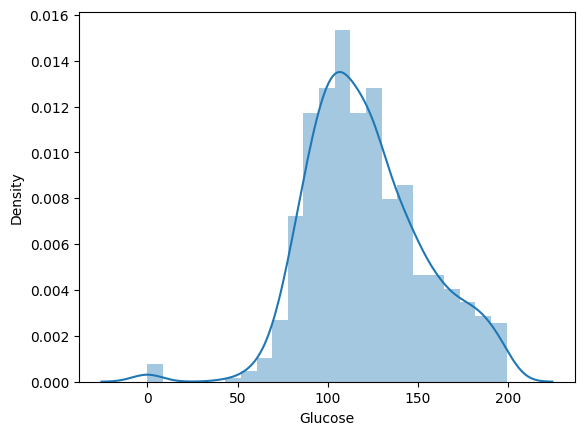

In [14]:
# plot the distribution of glucose features
sns.distplot(df['Glucose'])

/tmp/ipykernel_42725/733779589.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['BMI'])


<Axes: xlabel='BMI', ylabel='Density'>

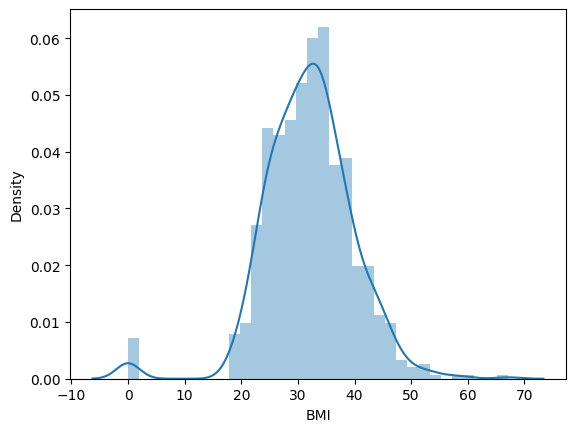

In [17]:
# plot the distribution of body mass index
sns.distplot(df['BMI'])

/tmp/ipykernel_42725/1810914026.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['BloodPressure'])


<Axes: xlabel='BloodPressure', ylabel='Density'>

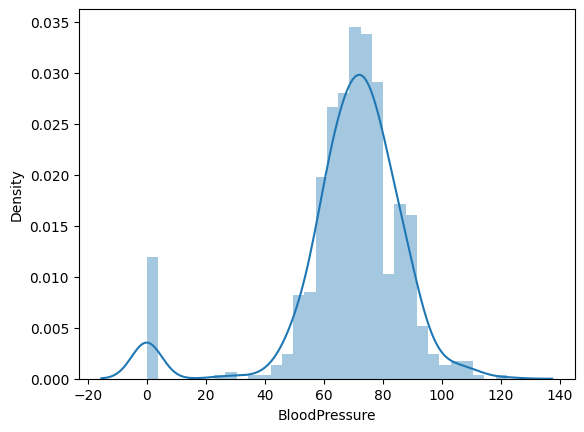

In [18]:
# plot the distribution of blood pressure
sns.distplot(df['BloodPressure'])

In [19]:
# split features and outcome
X = df.drop('Outcome' , axis = 1) #independent Feature
y = df['Outcome'] #dependent Feature

In [20]:
# Use scikit learn to easily split data into two sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y , test_size =0.2,random_state=0)

In [21]:
# Creating Tensors
X_train=torch.FloatTensor(X_train.values)
X_test=torch.FloatTensor(X_test.values)
y_train=torch.LongTensor(y_train.values)
y_test=torch.LongTensor(y_test.values)

In [22]:
# get the dimension of the entry
input_dim=X_train.shape[1]
print("Number of input features:",input_dim)

Number of input features: 8


In [23]:
#Creating the Model
class ANN_model(nn.Module):
    def __init__(self,input_features=input_dim,hidden1=20, hidden2=10,out_features=2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_features,hidden1)
        self.f_connected2 = nn.Linear(hidden1,hidden2)
        self.out = nn.Linear(hidden2,out_features)
        
    def forward(self,x):
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x

In [24]:
# declare an instance of the model and display parameters
#torch.manual_seed(20)
model = ANN_model()
model.parameters

<bound method Module.parameters of ANN_model(
  (f_connected1): Linear(in_features=8, out_features=20, bias=True)
  (f_connected2): Linear(in_features=20, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=2, bias=True)
)>

In [25]:
# declare loss function to use, as well as optimizer
# Backward Propergation - loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [26]:
epochs=5000
final_losses=[]
for i in range(epochs):
    i= i+1
    y_pred=model.forward(X_train)
    loss=loss_function(y_pred,y_train)
    final_losses.append(loss.item())
    if i % 100 == 0:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch number: 100 and the loss : 0.5581228137016296
Epoch number: 200 and the loss : 0.491642564535141
Epoch number: 300 and the loss : 0.4556275010108948
Epoch number: 400 and the loss : 0.41178587079048157
Epoch number: 500 and the loss : 0.429347425699234
Epoch number: 600 and the loss : 0.38451138138771057
Epoch number: 700 and the loss : 0.3857349753379822
Epoch number: 800 and the loss : 0.3864310085773468
Epoch number: 900 and the loss : 0.3616735637187958
Epoch number: 1000 and the loss : 0.356423556804657
Epoch number: 1100 and the loss : 0.3508402109146118
Epoch number: 1200 and the loss : 0.3606816232204437
Epoch number: 1300 and the loss : 0.35817819833755493
Epoch number: 1400 and the loss : 0.3468031883239746
Epoch number: 1500 and the loss : 0.3331637680530548
Epoch number: 1600 and the loss : 0.3199506998062134
Epoch number: 1700 and the loss : 0.31702834367752075
Epoch number: 1800 and the loss : 0.3205781579017639
Epoch number: 1900 and the loss : 0.3144074082374573
E

Text(0, 0.5, 'Epochs')

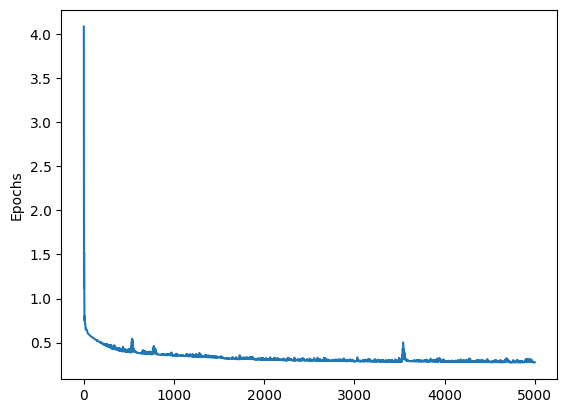

In [27]:
#plot the loss function
plt.plot(range(epochs),final_losses)
plt.ylabel('Loss')
plt.ylabel('Epochs')

In [31]:
predictions = []
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_pred = model(data)
        predictions.append(y_pred.argmax().item())

Text(50.722222222222214, 0.5, 'Predicted')

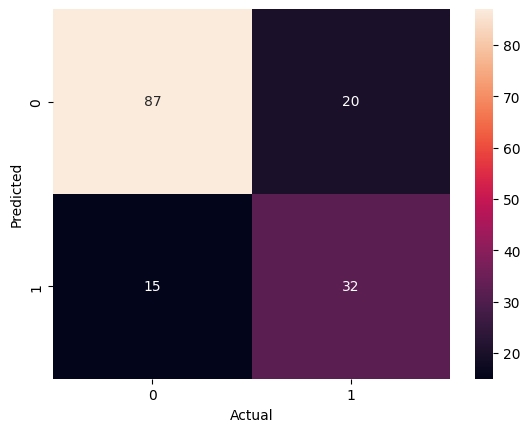

In [32]:
cm = confusion_matrix(y_test,predictions)
cm
sns.heatmap(cm,annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')

### TODO:
- try to improve and play with different parameters (optimizer, hyperparameters, network structure, etc)
- train a classifier on the customer dataset (seen during practical session logistic): can we improve over logistic regression?
- train a NN for prediction, compare with results obtained during last sessions (TP-Regression)

## Learn MNIST classifier (lecun net)

In [37]:
%matplotlib inline
!pip install plotly_express
import numpy as np
import torch,torchvision
import matplotlib.pyplot as plt
import plotly_express as px
import matplotlib.pyplot as plt
import os
from mpl_toolkits import mplot3d
from plotly.offline import download_plotlyjs, init_notebook_mode
from plotly.offline import plot, iplot

  Using cached plotly_express-0.4.1-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
Using cached plotly_express-0.4.1-py2.py3-none-any.whl (2.9 kB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 742.4 kB/s eta 0:00:0000:0100:01
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [39]:
class MnistModel(nn.Module):
    def __init__(self):
        super(MnistModel, self).__init__()
        # input is 28x28
        # padding=2 for same padding
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        # feature map size is 14*14 by pooling
        # padding=2 for same padding
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        # feature map size is 7*7 by pooling
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)   # reshape Variable
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
model = MnistModel()
model

MnistModel(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [40]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:41<00:00, 239kB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 217kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:03<00:00, 526kB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 373kB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [41]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

In [42]:
for p in model.parameters():
    print(p.size())

torch.Size([32, 1, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([1024, 3136])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


In [43]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [44]:
model.train()
train_loss = []
train_accu = []
i = 0
for epoch in range(1):
    for data, target in train_loader:
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        #loss = F.cross_entropy(output, target)
        loss.backward()    # calc gradients
        train_loss.append(loss.item())
        optimizer.step()   # update gradients
        prediction = output.data.max(1)[1]   # first column has actual prob.
        accuracy = prediction.eq(target.data).sum()/batch_size*100
        train_accu.append(accuracy)
        if i % 100 == 0:
            print('Train Step: {}\tLoss: {:.3f}\tAccuracy: {:.3f}'.format(i, loss.item(), accuracy))
        i += 1

/tmp/ipykernel_42725/2625365386.py:21: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Train Step: 0	Loss: 2.301	Accuracy: 6.000
Train Step: 100	Loss: 0.623	Accuracy: 84.000
Train Step: 200	Loss: 0.575	Accuracy: 78.000
Train Step: 300	Loss: 0.292	Accuracy: 94.000
Train Step: 400	Loss: 0.108	Accuracy: 98.000
Train Step: 500	Loss: 0.195	Accuracy: 96.000
Train Step: 600	Loss: 0.125	Accuracy: 98.000
Train Step: 700	Loss: 0.166	Accuracy: 94.000
Train Step: 800	Loss: 0.131	Accuracy: 96.000
Train Step: 900	Loss: 0.164	Accuracy: 96.000
Train Step: 1000	Loss: 0.178	Accuracy: 98.000
Train Step: 1100	Loss: 0.131	Accuracy: 96.000


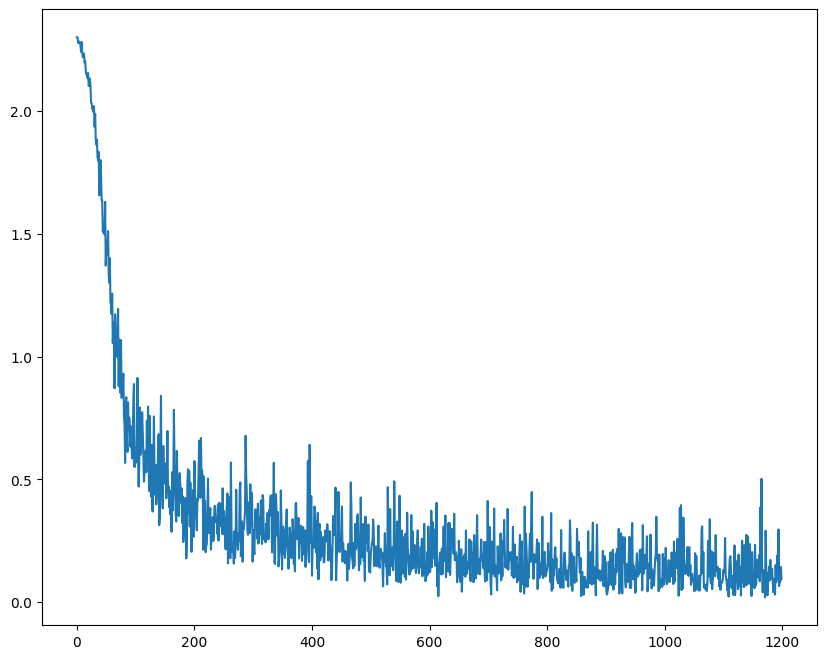

In [45]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(train_loss)), train_loss)

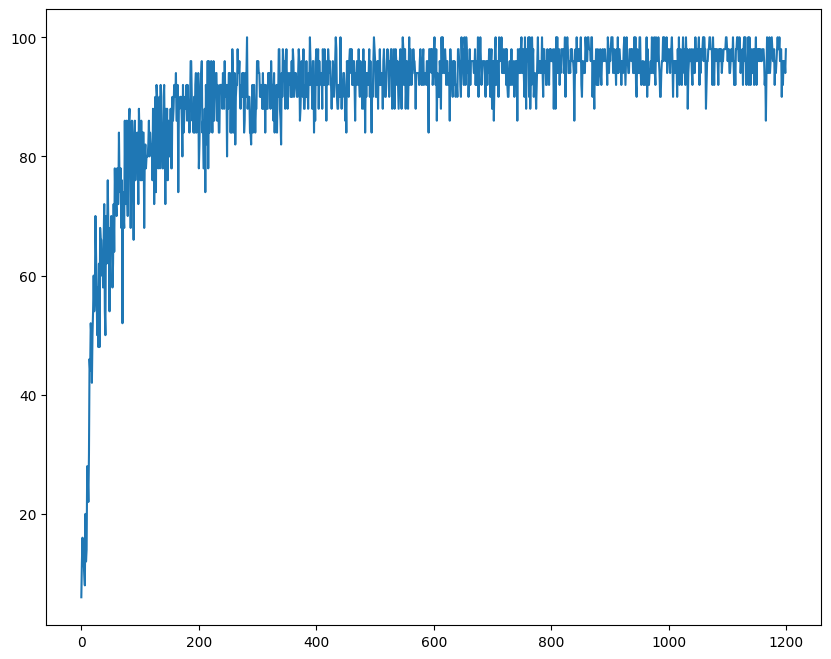

In [46]:
plt.figure(figsize = (10,8))
plt.plot(np.arange(len(train_accu)), train_accu)

In [47]:
model.eval()
correct = 0
for data, target in test_loader:
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()

print('\nTest set: Accuracy: {:.2f}%'.format(100. * correct / len(test_loader.dataset)))

/tmp/ipykernel_42725/302777914.py:4: UserWarning:

volatile was removed and now has no effect. Use `with torch.no_grad():` instead.

/tmp/ipykernel_42725/2625365386.py:21: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




Test set: Accuracy: 97.43%
